In [1]:
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime,timedelta
import random
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.stem import PorterStemmer
from collections import defaultdict

In [2]:
user_index = json.load(open("../data/user_index.json",'r'))
commitment_index = json.load(open("../data/commitment_index.json",'r'))

In [3]:
max_user_id = max([int(i) for i in user_index.keys()])

In [4]:
for k,v in tqdm(user_index.items()):
    user_index[k]['date'] = datetime.strptime(v['date'], '%d %b %Y')

  0%|          | 0/521632 [00:00<?, ?it/s]

In [5]:
id_for_1_jan_2023 = 722621
for k,v in tqdm(user_index.items()):
    if int(k)<id_for_1_jan_2023 and v['date'].year == 2023:
        user_index[k]['date'] = None

  0%|          | 0/521632 [00:00<?, ?it/s]

In [6]:
last_date = user_index['1']['date']
for i in range(1, max_user_id+1):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date'] == None:
            user_index[str(i)]['date'] = last_date
        else:
            last_date = user_index[str(i)]['date']

In [7]:
for k,v in tqdm(commitment_index.items()):
    commitment_index[k]['start_date'] = datetime.strptime(v['start_date'], '%B %d, %Y')
    commitment_index[k]['end_date'] = datetime.strptime(v['end_date'], '%B %d, %Y')

  0%|          | 0/319928 [00:00<?, ?it/s]

In [8]:
for k,v in tqdm(commitment_index.items()):
    if v['start_date'].year < 2007:
        deta = v['end_date'] - v['start_date']
        commitment_index[k]['start_date'] = user_index[str(v['user_id'])]['date']
        commitment_index[k]['end_date'] = commitment_index[k]['start_date'] + deta

  0%|          | 0/319928 [00:00<?, ?it/s]

Extract data

In [9]:
len(commitment_index)

319928

In [10]:
ps = PorterStemmer()

In [11]:
def preprocess_title(title):
    title = title.replace("/"," ")
    tokens = nltk.word_tokenize(title)
    tokens = [i.lower() for i in tokens]
    tokens = [i.translate(str.maketrans('', '', string.punctuation)) for i in tokens]
    tokens = [ps.stem(i) for i in tokens]
    return tokens

In [12]:
term_dict = {
    "weight":["weight","diet","fat", "pound", "kg", "calories",'kilos','pounds','kcal'],
    "eat":["eat","chocolate", "water", "food", "sugar", "softdrinks", "candy", "desserts", "veggies","gluten", "lactose", "snacking", "coffee","beverage","shakes", "caffeine"],
    "exercise":["exercise","run", "walk","race", "cycling","work-out","workout", "bicyclng","gym","km","steps", 'miles',"fitness", "yoga",'cardio','squats','deadlift',"climbing", "hike","pushup","pullup","healthy"],
    "smoking":["smoking"],
    "alcohol":['alcohol','drink','beer','wine','booze'],
    "sleep":["sleep","bed","wake",'asleep','nap'],
    "read":["read","book"],
    "study":["study","exam","diploma", "phd", "assignment", "math","gmat",'homework', 'gre', 'sat', 'school', 'learn',"thesis", "degree",'certification', "preparation","dissertation", "class", "course","english","french","spanish","java","experiments"],
    "write":["write","draft", "screenplay","scripts",'copywriting'],
    "mastrubate":["mastrubate","mastrubation","porn","masturbation",'nofap','fap','porngraphy'],
    "meditate":["meditate","journal"],
    "money":["money","finance","saving", "expense", "spending", "earn", "save",'budget','buy','invest','cash','debt'],
    "nail":["nail","hair", "brush", "floss","shower"],
    "client":["client","job","business",'network', "inbox", "emails",'career'],
    "procrastinating":["procrastinating","procrastinate","procrastination",'productive'],
    "clean":["clean","laundry", "tidy"],
    "internet":["internet", "electronics",'tv','phone',"mobile", "games"]
}

In [13]:
term_dict_n_gram = {
    "weight":['in shape'],
    "exercise":["work out", "push up", "pull up"],
    "sleep":['wake up','get up'],
    "internet":["social media"]
}

In [14]:
term_dict = {k:[ps.stem(i) for i in v] for k,v in term_dict.items()}

In [15]:
count_dict = {k:[] for k in term_dict.keys()}

term_count = {k:{i:[] for i in v} for k,v in term_dict.items()}

for k,v in term_dict_n_gram.items():
    for i in v:
        term_count[k][i] = []
        
term_count['money']['$'] = []

In [16]:
for k,v in tqdm(commitment_index.items()):
    pre_title = preprocess_title(v['title'])
    for t,rt in term_dict.items():
        for ct in rt:
            if ct in pre_title:
                count_dict[t].append(k)
                term_count[t][ct].append(k)
                
    pre_title = " ".join(pre_title)
    for t,rt in term_dict_n_gram.items():
        for ct in rt:
            if ct in pre_title:
                count_dict[t].append(k)
                term_count[t][ct].append(k)
                
    if "$" in v['title']:
        count_dict['money'].append(k)
        term_count['money']['$'].append(k)

  0%|          | 0/319928 [00:00<?, ?it/s]

In [17]:
for k,v in count_dict.items():
    count_dict[k] = list(set(v))
    
for k,v in term_count.items():
    for t,l in v.items():
        term_count[k][t] = list(set(l))

In [18]:
len(set([j for v in count_dict.values() for j in v]))

236581

In [19]:
len(set([j for v in count_dict.values() for j in v]))/len(commitment_index)

0.7394820084519017

In [20]:
# for k,v in count_dict.items():
#     print("-"*100)
#     print(k)
#     for j in random.sample(v,min(5,len(v))):
#         print(commitment_index[j]['title'])

### Overlap analysis

In [21]:
# res = list(combinations(count_dict.keys(), 2))
# total_intersection_count = 0
# for i in res:
#     intersection_count = set.intersection(*[set(count_dict[j]) for j in i])
#     total_intersection_count+=len(intersection_count)
#     if len(intersection_count)>0:
#         print("-"*50)
#         print(f"{i} {len(intersection_count)}")
#         for s in random.sample(list(intersection_count),min(5,len(intersection_count))):
#             print(commitment_index[s]['title'])

In [22]:
# total_intersection_count 

In [23]:
# res = list(combinations(count_dict.keys(), 3))
# total_intersection_count = 0
# for i in res:
#     intersection_count = set.intersection(*[set(count_dict[j]) for j in i])
#     total_intersection_count+=len(intersection_count)
#     if len(intersection_count)>0:
#         print("-"*50)
#         print(f"{i} {len(intersection_count)}")
#         for s in random.sample(list(intersection_count),min(5,len(intersection_count))):
#             print(commitment_index[s]['title'])

In [24]:
# total_intersection_count 

In [25]:
# RULES TO REMOVE WRONG OVERLAPS

for id_ in set(count_dict['eat']) & set(count_dict['alcohol']):
    if id_ in term_count['alcohol']['drink']:
        count_dict['alcohol'].remove(id_)
        
for id_ in set(count_dict['eat']) & set(count_dict['clean']):
    count_dict['clean'].remove(id_)
    
for id_ in set(count_dict['eat']) & set(count_dict['write']):
    count_dict['write'].remove(id_)

for id_ in set(count_dict['eat']) & set(count_dict['meditate']):
    if id_ in term_count['meditate']['journal']:
        count_dict['meditate'].remove(id_)
        
for id_ in set(count_dict['eat']) & set(count_dict['nail']):
    count_dict['eat'].remove(id_)
    
for id_ in set(count_dict['eat']) & set(count_dict['client']):
    count_dict['eat'].remove(id_)
    
for id_ in set(count_dict['eat']) & set(count_dict['procrastinating']):
    if id_ in term_count['procrastinating']['product']:
        count_dict['procrastinating'].remove(id_)
        
for id_ in set(count_dict['exercise']) & set(count_dict['nail']):
    if id_ in term_count['exercise']['healthi']:
        count_dict['exercise'].remove(id_)
        
for id_ in set(count_dict['exercise']) & set(count_dict['client']):
    count_dict['exercise'].remove(id_)
    
for id_ in set(count_dict['alcohol']) & set(count_dict['write']):
    count_dict['alcohol'].remove(id_)
    
for id_ in set(count_dict['alcohol']) & set(count_dict['clean']):
    count_dict['clean'].remove(id_)
    
for id_ in set(count_dict['sleep']) & set(count_dict['nail']):
    count_dict['sleep'].remove(id_)
    
for id_ in set(count_dict['sleep']) & set(count_dict['clean']):
    count_dict['sleep'].remove(id_)
    
for id_ in set(count_dict['read']) & set(count_dict['write']):
    if id_ in term_count['read']['book']:
        count_dict['read'].remove(id_)
        
for id_ in set(count_dict['read']) & set(count_dict['meditate']):
    if id_ in term_count['meditate']['journal']:
        count_dict['meditate'].remove(id_)
        
for id_ in set(count_dict['read']) & set(count_dict['client']):
    count_dict['read'].remove(id_)
    
for id_ in set(count_dict['read']) & set(count_dict['procrastinating']):
    count_dict['procrastinating'].remove(id_)
    
for id_ in set(count_dict['read']) & set(count_dict['clean']):
    count_dict['read'].remove(id_)
    
for id_ in set(count_dict['study']) & set(count_dict['write']):
    count_dict['write'].remove(id_)
    
for id_ in set(count_dict['write']) & set(count_dict['meditate']):
    if id_ in term_count['meditate']['journal']:
        count_dict['write'].remove(id_)
    
for id_ in set(count_dict['mastrubate']) & set(count_dict['nail']):
    count_dict['nail'].remove(id_)
    
for id_ in set(count_dict['meditate']) & set(count_dict['money']):
    count_dict['money'].remove(id_)
    
for id_ in set(count_dict['nail']) & set(count_dict['money']):
    count_dict['money'].remove(id_)
    
for id_ in set(count_dict['procrastinating']) & set(count_dict['money']):
    count_dict['procrastinating'].remove(id_)
    
for id_ in set(count_dict['internet']) & set(count_dict['money']):
    if id_ in term_count['money']['spend']:
        count_dict['money'].remove(id_)
        
for id_ in set(count_dict['internet']) & set(count_dict['money']):
    count_dict['internet'].remove(id_)
        
for id_ in set(count_dict['nail']) & set(count_dict['client']):
    count_dict['nail'].remove(id_)
    
for id_ in set(count_dict['nail']) & set(count_dict['clean']):
    count_dict['clean'].remove(id_)
    
for id_ in set(count_dict['client']) & set(count_dict['procrastinating']):
    count_dict['procrastinating'].remove(id_)
    
for id_ in set(count_dict['client']) & set(count_dict['clean']):
    count_dict['clean'].remove(id_)
    
for id_ in set(count_dict['internet']) & set(count_dict['client']):
    if id_ in term_count['client']['busi']:
        count_dict['internet'].remove(id_)
    else:
        count_dict['client'].remove(id_)
        
for id_ in set(count_dict['internet']) & set(count_dict['clean']):
    count_dict['internet'].remove(id_)

In [26]:
# cl1="exercise"
# cl2="money"

# intersection = list(set(count_dict[cl1]) & set(count_dict[cl2]))
# print(len(intersection))
# for i in random.sample(intersection, min(100,len(intersection))):
#     print(commitment_index[i]['title'])

# where breakes

In [27]:
classified = set([j for v in count_dict.values() for j in v])

In [28]:
len(classified)

236581

In [29]:
not_classified = set(commitment_index.keys())-classified

In [30]:
len(not_classified)

83347

In [31]:
# for k in random.sample(list(not_classified),10):
#     print(commitment_index[k]['title'])

# Analysis

# Summary Table

In [32]:
count_df = []
for k,v in count_dict.items():
    count_df.append([k,len(set(v)),len(set(v))*100/len(commitment_index)])
    
count_df.append(["Not Classified",len(not_classified), len(not_classified)*100/len(commitment_index)])

In [33]:
pd.DataFrame(count_df, columns=['Class','Count',"%"]).sort_values("Count",ascending=False)

,Class,Count,%
0,weight,88877,27.780313
17,Not Classified,83347,26.051799
2,exercise,71121,22.230314
7,study,16898,5.281813
1,eat,11345,3.546110
3,smoking,8512,2.660599
11,money,6533,2.042022
5,sleep,6457,2.018267
6,read,6280,1.962942
10,meditate,5204,1.626616


### Intersection Analysis

In [34]:
intersection_data = {}
intersection_count_data = []


res = list(combinations(count_dict.keys(), 2))
total_intersection_count = 0
for i in res:
    intersection_count = list(set.intersection(*[set(count_dict[j]) for j in i]))
    if len(intersection_count)>0:
        intersection_data["_".join(i)]=intersection_count
        total_intersection_count+=len(intersection_count)
        intersection_count_data.append([i,len(intersection_count)])
    
res = list(combinations(count_dict.keys(), 3))
for i in res:
    intersection_count = list(set.intersection(*[set(count_dict[j]) for j in i]))
    if len(intersection_count)>0:
        intersection_data["_".join(i)]=intersection_count
        total_intersection_count+=len(intersection_count)
        intersection_count_data.append([i,len(intersection_count)])

In [35]:
total_intersection_count

4828

In [37]:
pd.DataFrame(intersection_count_data, columns=['Classes','Count']).sort_values("Count",ascending=False).head(50)

,Classes,Count
15,"(eat, exercise)",1354
1,"(weight, exercise)",503
0,"(weight, eat)",371
59,"(read, study)",207
30,"(exercise, study)",171
67,"(study, money)",157
23,"(eat, money)",144
28,"(exercise, sleep)",117
33,"(exercise, meditate)",112
69,"(study, client)",100


In [38]:
with open("../data/Topic_model_classes.json",'w') as fp:
    json.dump(count_dict,fp,indent=4)
    
with open("../data/Topic_model_overlap_commitments.json",'w') as fp:
    json.dump(intersection_data,fp,indent=4)

Year wise

In [39]:
# year_count = {i:{k:0 for k in count_dict.keys()} for i in range(2007,2024)}
year_count = {k:{i:0 for i in range(2007,2024)} for k in count_dict.keys()}
total_year = {i:0 for i in range(2007,2024)}

In [40]:
for k,v in count_dict.items():
    for i in set(v):
        year_count[k][commitment_index[i]['start_date'].year]+=1
        total_year[commitment_index[i]['start_date'].year]+=1

In [41]:
for k,v in year_count.items():
    for y,c in v.items():
        year_count[k][y]=c*100/total_year[y]

In [42]:
year_data = pd.DataFrame.from_dict(year_count)

In [43]:
year_data['year'] = year_data.index

In [44]:
year_data

,weight,eat,exercise,smoking,alcohol,sleep,read,study,write,mastrubate,meditate,money,nail,client,procrastinating,clean,internet,year
2007,15.789474,0.000000,31.578947,39.473684,0.000000,0.000000,5.263158,0.000000,2.631579,0.000000,0.000000,2.631579,0.000000,0.000000,0.000000,2.631579,0.000000,2007
2008,53.231853,2.340111,27.854141,3.862320,0.590708,0.761104,0.851982,3.635124,1.022379,0.022720,0.352153,3.158014,0.590708,0.567988,0.181756,0.499830,0.477110,2008
2009,53.769694,4.007613,25.208840,3.404885,0.877657,0.898805,1.300624,3.764407,1.374643,0.042297,0.518135,2.347467,0.359522,1.046844,0.285503,0.359522,0.433541,2009
2010,56.389544,2.659285,25.340352,3.303685,0.707932,0.844073,1.316028,3.085860,1.288800,0.063532,0.417499,2.350699,0.263206,0.962062,0.181521,0.444727,0.381194,2010
2011,49.441870,3.401005,27.090541,3.538090,0.855147,1.534043,1.605849,5.026438,1.723350,0.078334,0.554867,2.467524,0.398198,1.155428,0.176252,0.509172,0.443893,2011
2012,46.963118,3.660749,27.032375,3.369428,1.154290,1.896334,1.533557,5.661518,1.940307,0.247348,0.670588,2.808773,0.296817,1.341175,0.263838,0.412246,0.747540,2012
2013,41.757352,3.720200,27.701574,3.173559,1.331174,2.358658,1.872754,7.334109,2.237182,0.480842,1.012299,3.102698,0.404920,1.725971,0.409981,0.622564,0.754163,2013
2014,39.905941,5.054455,28.282178,3.856436,1.267327,2.123762,2.064356,7.341584,2.000000,0.668317,1.113861,2.995050,0.376238,1.400990,0.346535,0.500000,0.702970,2014
2015,32.364483,4.247704,34.274872,4.174393,1.078097,2.320066,2.514123,8.215102,2.126008,0.659796,1.345466,2.988486,0.478675,1.483462,0.396740,0.629609,0.702919,2015
2016,31.174439,4.447323,32.806563,3.860104,1.217617,2.586356,2.879965,8.868739,2.430915,0.820380,2.158895,2.772021,0.487910,1.593264,0.582902,0.582902,0.729706,2016


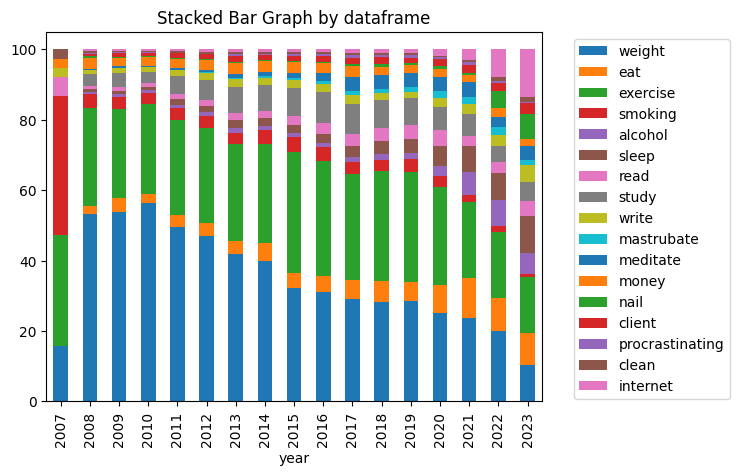

In [45]:
year_data.plot(x='year', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# Month wise

In [46]:
month_count = {k:{i:0 for i in range(1,13)} for k in count_dict.keys()}
total_month = {i:0 for i in range(1,13)}

In [47]:
for k,v in count_dict.items():
    for i in set(v):
        month_count[k][commitment_index[i]['start_date'].month]+=1
        total_month[commitment_index[i]['start_date'].month]+=1

In [48]:
for k,v in month_count.items():
    for m,c in v.items():
        month_count[k][m]=c*100/total_month[m]

In [49]:
month_data = pd.DataFrame.from_dict(month_count)

In [50]:
month_data['month'] = month_data.index

In [51]:
month_data

,weight,eat,exercise,smoking,alcohol,sleep,read,study,write,mastrubate,meditate,money,nail,client,procrastinating,clean,internet,month
1,39.329761,4.288819,30.491812,3.060554,1.384958,2.385766,2.782552,5.671249,1.690760,0.449858,2.365548,2.792661,0.457440,1.256066,0.391731,0.419531,0.780934,1
2,36.017244,4.899643,30.839475,3.476568,1.372085,2.739536,2.475316,6.786261,2.076670,0.686043,1.993232,2.415056,0.630418,1.687294,0.477449,0.509897,0.917814,2
3,37.564364,4.930535,29.758088,3.346935,1.306713,2.598854,2.064510,7.111629,1.729331,0.680074,1.894491,2.730011,0.548917,1.782765,0.403187,0.505198,1.044399,3
4,37.579583,4.832127,29.058062,3.455406,1.442020,2.595636,2.432388,7.144801,2.182075,0.761822,2.154867,2.465038,0.565925,1.447462,0.435327,0.516951,0.930511,4
5,37.774967,5.229872,28.013638,3.569072,1.358337,2.672679,2.485702,7.292125,2.304223,0.857897,1.935768,2.419710,0.549934,1.561813,0.390453,0.582930,1.000880,5
6,37.510556,4.700783,28.778922,3.625514,1.373642,2.544615,2.443281,6.783764,2.206834,0.827563,2.049203,3.242695,0.608005,1.525643,0.309632,0.591116,0.878230,6
7,36.566994,4.616526,28.692079,3.492353,1.489386,2.642091,2.779046,6.899110,2.316823,0.724720,2.585026,2.921707,0.536407,1.700525,0.576352,0.673362,0.787491,7
8,35.792779,4.697500,28.861249,3.441613,1.600048,3.024997,2.904239,7.366260,2.185726,0.845309,2.324598,2.578191,0.627943,1.606086,0.609830,0.567564,0.966067,8
9,34.723141,4.737481,29.969115,3.904699,1.478050,2.481800,2.465255,8.052063,2.128833,1.003750,1.902713,3.027796,0.557026,1.571807,0.375028,0.623208,0.998235,9
10,36.076475,4.871155,29.071765,3.563314,1.501801,2.804101,2.715434,7.908008,2.122472,0.836797,1.939595,2.560266,0.559712,1.396509,0.498753,0.565254,1.008590,10


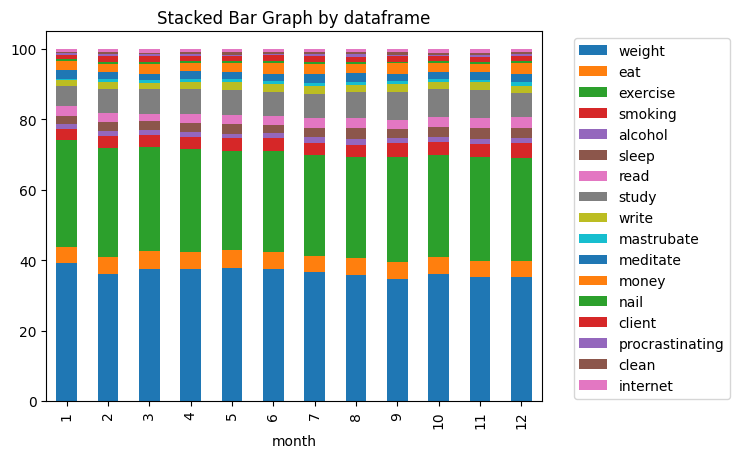

In [52]:
month_data.plot(x='month', kind='bar', stacked=True,
        title='Stacked Bar Graph by dataframe')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')